In [ ]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import plotly.express as ex
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from PIL import Image
import torch
import random
from torchvision import transforms
from keras.preprocessing.image import ImageDataGenerator

In [2]:
df_train=pd.read_csv("/kaggle/input/ai-of-god-v20/train.csv")
df_test=pd.read_csv("/kaggle/input/ai-of-god-v20/test.csv")
df=pd.read_csv("/kaggle/input/ai-of-god-v20/sample_submission.csv")

## DIFFERENT CLASSES AND ITS PERCENTAGE

In [3]:
ex.pie(df_train,names='Class',hole=0.4)

## FEW IMAGES

<function matplotlib.pyplot.show(close=None, block=None)>

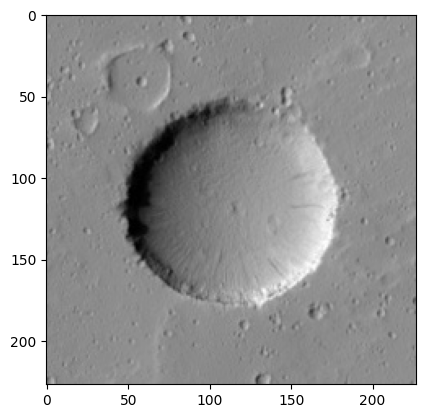

In [7]:
img = cv2.imread('/kaggle/input/ai-of-god-v20/train/10.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

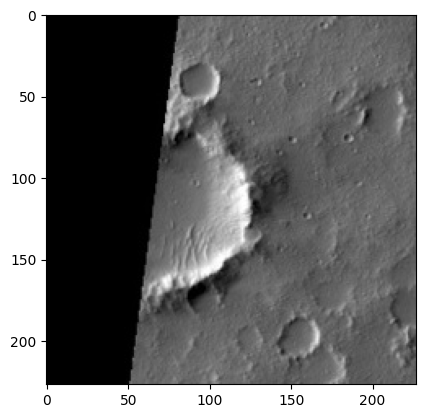

In [12]:
img = cv2.imread('/kaggle/input/ai-of-god-v20/train/121.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

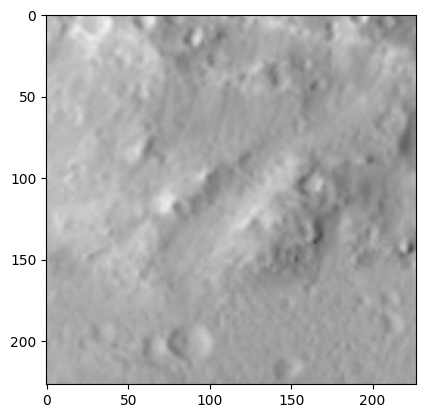

In [13]:
img = cv2.imread('/kaggle/input/ai-of-god-v20/train/1215.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show

## DATA AUGMENTATION AND STORING

In [3]:
folder_path = '/kaggle/input/ai-of-god-v20/train/'
file_list = os.listdir(folder_path)
csv_file = '/kaggle/input/ai-of-god-v20/train.csv'
targets = {}
num=0
with open(csv_file, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for row in csvreader:
        filename, target = row
        targets[filename] = int(target)
train_img = []
y_class = []
transform = transforms.Compose([transforms.ToTensor()])
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
])

for filename in file_list:
    img = cv2.imread(os.path.join(folder_path, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=transform(img)
    target = targets.get(filename, None)
    if target is not None:
        if target==0:
            if num%3==0:
                y_class.append(target)
                train_img.append(img)
            num+=1
        elif target==1:
            y_class.append(target)
            train_img.append(img)
        elif target==2:
            for j in range(0,5):
                y_class.append(target)
            train_img.append(img)
            for j in range(0,4):
                train_img.append(data_augmentation(img))
        elif target==3:
            for j in range(0,3):
                y_class.append(target)
            train_img.append(img)
            for j in range(0,2):
                train_img.append(data_augmentation(img))
        elif target==4:
            for j in range(0,2):
                y_class.append(target)
            train_img.append(img)
            for j in range(0,1):
                train_img.append(data_augmentation(img))
        elif target==5:
            for j in range(0,20):
                y_class.append(target)
            train_img.append(img)
            for j in range(0,19):
                train_img.append(data_augmentation(img))
        elif target==6:
            for j in range(0,4):
                y_class.append(target)
            train_img.append(img)
            for j in range(0,3):
                train_img.append(data_augmentation(img))
        elif target==7:
            for j in range(0,15):
                y_class.append(target)
            train_img.append(img)
            for j in range(0,14):
                train_img.append(data_augmentation(img))
train_img = torch.stack(train_img)
y_class = torch.tensor(y_class)

    

## CONVERTION OF TEST IMG TO RGB

In [4]:
folder_path = '/kaggle/input/ai-of-god-v20/test/'
file_list = os.listdir(folder_path)
num = len(file_list)
test_img = []
for i in range(1,num+1):
    filename=str(i)+'.jpg'
    img = cv2.imread(os.path.join(folder_path, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_img.append(img)

## TRANSFORMING Y FROM 1D TO 2D. Y=3 TO Y=[0,0,0,1,0,0,0]

In [5]:
train_img = train_img.permute(0, 2, 3, 1)
train_img = train_img.numpy()
y_class1 = y_class.numpy()
map = {}
y_class1 = y_class1.flatten()
for id,num in enumerate(np.unique(y_class1)):
    map[num] = id
y_class = np.zeros([y_class1.shape[0],len(np.unique(y_class1))],dtype=int)
for i,j in enumerate(y_class1):
    y_class[i,map[j]] = 1
train_img = tf.convert_to_tensor(train_img)
y_class = tf.convert_to_tensor(y_class)

In [ ]:
inception = InceptionV3(input_shape=[227, 227, 3], weights='imagenet', include_top=False)
for layer in inception.layers:
    layer.trainable = False
x = Flatten()(inception.output)
#prediction = Dense(128, activation='relu', kernel_regularizer=l2(0.02))(x)
prediction = Dense(8, activation='softmax', kernel_regularizer=l2(0.008))(x)
model_i = Model(inputs=inception.input, outputs=prediction)
model_i.summary()

In [7]:
model_i.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model_i.fit(
    train_img,
    y_class,
    batch_size=32,
    epochs=9,
    validation_split=0.3,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.00001)],
    shuffle=True
)

Epoch 1/9
245/245 [==============================] - 663s 3s/step - loss: 0.3551 - accuracy: 0.8556 - val_loss: 0.2808 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 2/9
245/245 [==============================] - 723s 3s/step - loss: 0.2065 - accuracy: 0.9274 - val_loss: 0.2848 - val_accuracy: 0.8821 - lr: 0.0010
Epoch 3/9
245/245 [==============================] - 684s 3s/step - loss: 0.2237 - accuracy: 0.9334 - val_loss: 0.3095 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 4/9
245/245 [==============================] - 677s 3s/step - loss: 0.1391 - accuracy: 0.9773 - val_loss: 0.1500 - val_accuracy: 0.9160 - lr: 3.0000e-04
Epoch 5/9
245/245 [==============================] - 671s 3s/step - loss: 0.0693 - accuracy: 0.9932 - val_loss: 0.1158 - val_accuracy: 0.9157 - lr: 3.0000e-04
Epoch 6/9
245/245 [==============================] - 659s 3s/step - loss: 0.0513 - accuracy: 0.9909 - val_loss: 0.0981 - val_accuracy: 0.9157 - lr: 3.0000e-04
Epoch 7/9
245/245 [==============================] - 666s 

### GRAPH

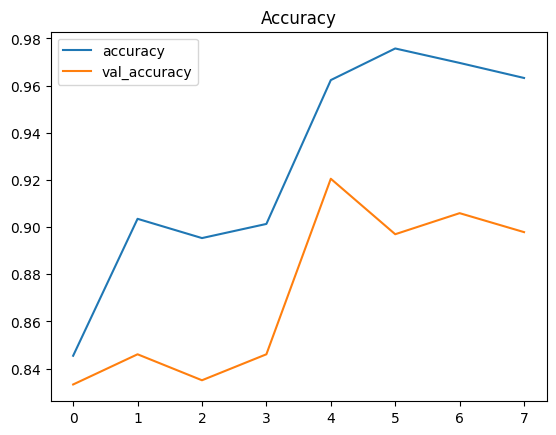

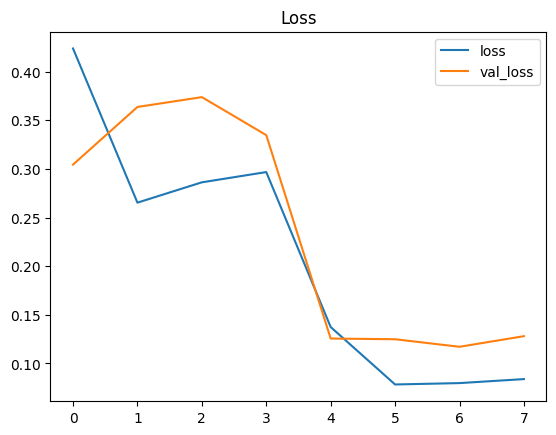

In [8]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()
model_i.save('/kaggle/working/model_inceptionv3_r.h5')

In [ ]:
test_img=np.array(test_img)
test_img=test_img/255
test_img = tf.convert_to_tensor(test_img)

## PREDICTION

In [ ]:
val = model_i.predict(test_img)
val = np.argmax(val, axis=1)
df['Class'] = val
df.to_csv('new_i.csv', index=False)

## OUTPUT CLASSES IN FORM OF PIE CHART

In [14]:
ex.pie(df,names='Class',hole=0.4)